# Compact architectures
## Audio Classification with the NBAC dataset

This notebook performs audio classification on audio fragments of 2 seconds long

In [1]:
# IMPORT ALL LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Load the data

### ESC-50 dataset

In [2]:
# Set sample rate to work with at 8000

SR = 16000

In [3]:
!git clone https://github.com/DavidCastello/NBAC.git

Cloning into 'NBAC'...
remote: Enumerating objects: 734, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 734 (delta 2), reused 86 (delta 2), pack-reused 647
Receiving objects: 100% (734/734), 443.54 MiB | 27.38 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (723/723), done.


In [4]:
def map_subfolders_to_int(path):
    reversed_labels = {}
    counter = 0

    # Walk through the directory
    for root, dirs, files in os.walk(path):
        # For each subdirectory
        for dir in dirs:
            # Add the subdirectory to the dictionary with the current count as the key
            reversed_labels[counter] = dir
            counter += 1

    return reversed_labels

# Specify your directory path here
directory_path = "/kaggle/working/NBAC/audio"
reversed_labels = map_subfolders_to_int(directory_path)
print(reversed_labels)

{0: 'rain', 1: 'silence', 2: 'siren', 3: 'coughing', 4: 'bed movement', 5: 'snoring', 6: 'traffic', 7: 'loud breathing', 8: 'sneezing', 9: 'talking', 10: 'dog bark', 11: 'wind'}


In [5]:
NUM_CLASSES = len(reversed_labels)

In [6]:
def reverse_dict(original_dict):
    reversed_dict = {value: key for key, value in original_dict.items()}
    return reversed_dict

# reversed dictionary
labels_dict = reverse_dict(reversed_labels)
print(labels_dict)

{'rain': 0, 'silence': 1, 'siren': 2, 'coughing': 3, 'bed movement': 4, 'snoring': 5, 'traffic': 6, 'loud breathing': 7, 'sneezing': 8, 'talking': 9, 'dog bark': 10, 'wind': 11}


### Load the wav files

In [7]:
NBAC_FOLDER = '/kaggle/working/NBAC/audio'

In [8]:
def wav_data_loader(directory, sr=SR, normalization=True):
    all_fragments = []
    for root, dirs, _ in os.walk(directory):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
            for file in files:
                file_path = os.path.join(dir_path, file)
                # Load the audio file
                sample, sample_rate = librosa.load(file_path, sr=sr)
                if normalization:
                    # Normalize the waveform
                    sample = librosa.util.normalize(sample)
                # Append the sample and its label (subfolder name) as a tuple
                all_fragments.append((sample, labels_dict[dir]))
    return all_fragments

In [9]:
%%time
nbac_wav_dataset = wav_data_loader(NBAC_FOLDER, normalization=False)
len(nbac_wav_dataset)

CPU times: user 13.6 s, sys: 730 ms, total: 14.3 s
Wall time: 16.9 s


720

## Train-test split

Creating a first train-test split in the original dataset will be useful for correct data augmentation and pre-processing techniques.

In [10]:
X = [wav[0] for wav in nbac_wav_dataset]
y = [wav[1] for wav in nbac_wav_dataset]

X_train_wav, X_test_wav, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_wav, X_val_wav, y_train, y_val = train_test_split(X_train_wav, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Waveform augmentation

In [11]:
## Noise addition

def add_noise(wav_data, noise_factor):

    # Generate noise signal with the same shape as input waveform
    noise = np.random.normal(0, 1, len(wav_data))

    # Scale noise signal with the permissible noise factor value
    noise *= noise_factor

    # Add noise signal to input waveform
    augmented_wav_data = wav_data + noise

    # Normalize the augmented waveform data
    augmented_wav_data = librosa.util.normalize(augmented_wav_data)

    return augmented_wav_data

def time_shift(audio, p):
    """
    Shift audio to the left or right by a random amount.
    """
    # Calculate the length of the audio array
    length = audio.shape[0]

    # Calculate the maximum number of samples to shift
    max_shift = int(length * p)

    # Generate a random shift value
    shift = random.randint(-max_shift, max_shift)

    # Create an empty array with the same shape as the audio array
    shifted_audio = np.zeros_like(audio)

    # Shift the audio by the specified number of samples
    if shift > 0:
      # Shift to the right
        shifted_audio[shift:] = audio[:length-shift]
    else:
        # Shift to the left
        shifted_audio[:length+shift] = audio[-shift:]
    
    if np.sum(shifted_audio) == 0:
        #revert the process if all information was erased
        shifted_audio = audio     

    return shifted_audio

def time_stretching(audio,factor):
    
    wav_time_stch = librosa.effects.time_stretch(audio,rate=factor)
    
    return wav_time_stch[:SR*5]

In [12]:
%%time
''' EXUCUTE THIS CELL TO APPLY DATA AUGMENTATION
Lots of memory required this step could be optimized'''

def augment_wavs(wav_dataset, y):
    
    wav_dataset_augmented = []

    for wav in wav_dataset:
        # Create a copy of the original wav to prevent unwanted side effects
        temp_wav = wav.copy()
        temp_wav = add_noise(temp_wav, 0.025) # We want to use values between 0.005 and 0.04
        temp_wav = time_shift(temp_wav, 0.3)  # We want to use a max shift of 30%
        temp_wav = time_stretching(temp_wav, 0.85)

        wav_dataset_augmented.append(temp_wav)

    # Add original wavs to augmented list
    wav_dataset_augmented.extend(wav_dataset)
    
    y = y + y #each spec is being appended at the bottom of the list

    return wav_dataset_augmented, y

X_train_wav, y_train = augment_wavs(X_train_wav, y_train)


CPU times: user 24.2 s, sys: 230 ms, total: 24.4 s
Wall time: 24.9 s


## Split the waveforms

In [13]:
def split_waveforms(X_wav, y, sample_rate=SR, window_size=2, hop_size=0.5):
    
    # Define window size and hop size in samples
    window_size = window_size * sample_rate 
    hop_size = hop_size * sample_rate

    X_segments = []
    y_segments = []

    for i, waveform in enumerate(X_wav):
        for start in np.arange(0, waveform.size - window_size + 1, hop_size):
            end = start + window_size
            segment = waveform[int(start):int(end)]
            X_segments.append(segment)
            y_segments.append(y[i])  # Use the same label for the segment

    return X_segments, y_segments

In [14]:
X_train_wav, y_train = split_waveforms(X_train_wav, y_train)

In [15]:
X_val_wav, y_val = split_waveforms(X_val_wav, y_val)

In [16]:
X_test_wav, y_test = split_waveforms(X_test_wav, y_test)

# Training

## Basic CNN architecture

In [17]:
class LLF(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)

        return log_mel_spectrogram

sample_rate = SR  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
AUDIO_LENGTH = 2

class HLFBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HLFBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        ])

    def call(self, inputs):
        return self.seq(inputs)

class EmbeddingsBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EmbeddingsBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GlobalAveragePooling2D(),
        ])

    def call(self, inputs):
        return self.seq(inputs)
    
HLF = HLFBlock(name='HLF')
Embeddings = EmbeddingsBlock(name='Embeddings')

# Define the model
model = Sequential([
    LLF(sample_rate, frame_length, frame_step, input_shape=(AUDIO_LENGTH*SR,)),
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_wav), np.array(y_val)))

Epoch 1/50


2023-06-17 16:48:27.250877: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/Embeddings/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


177/177 [==============================] - 20s 18ms/step - loss: 1.8816 - accuracy: 0.3561 - val_loss: 2.3260 - val_accuracy: 0.2263
Epoch 2/50
177/177 [==============================] - 2s 11ms/step - loss: 1.3841 - accuracy: 0.5186 - val_loss: 1.3969 - val_accuracy: 0.5233
Epoch 3/50
177/177 [==============================] - 2s 12ms/step - loss: 1.0968 - accuracy: 0.6303 - val_loss: 0.9320 - val_accuracy: 0.6690
Epoch 4/50
177/177 [==============================] - 2s 12ms/step - loss: 0.9061 - accuracy: 0.6935 - val_loss: 0.7247 - val_accuracy: 0.8006
Epoch 5/50
177/177 [==============================] - 2s 11ms/step - loss: 0.7702 - accuracy: 0.7426 - val_loss: 0.9673 - val_accuracy: 0.7270
Epoch 6/50
177/177 [==============================] - 2s 12ms/step - loss: 0.6803 - accuracy: 0.7644 - val_loss: 1.7665 - val_accuracy: 0.5035
Epoch 7/50
177/177 [==============================] - 2s 12ms/step - loss: 0.6129 - accuracy: 0.7900 - val_loss: 0.8603 - val_accuracy: 0.7298
Epoch 8/5

In [18]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

48/48 - 0s - loss: 1.3569 - accuracy: 0.7632 - 325ms/epoch - 7ms/step
Test loss: 1.3569039106369019
Test accuracy: 0.7632275223731995


In [19]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 129676


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf (LLF)                   (None, 198, 64, 1)        0         
                                                                 
 HLF (HLFBlock)              (None, 12, 4, 128)        93568     
                                                                 
 Embeddings (EmbeddingsBlock  (None, 256)              33024     
 )                                                               
                                                                 
 dense (Dense)               (None, 12)                3084      
                                                                 
 activation (Activation)     (None, 12)                0         
                                                                 
Total params: 129,676
Trainable params: 129,228
Non-trainable params: 448
______________________________________________

### Visualization of the training process

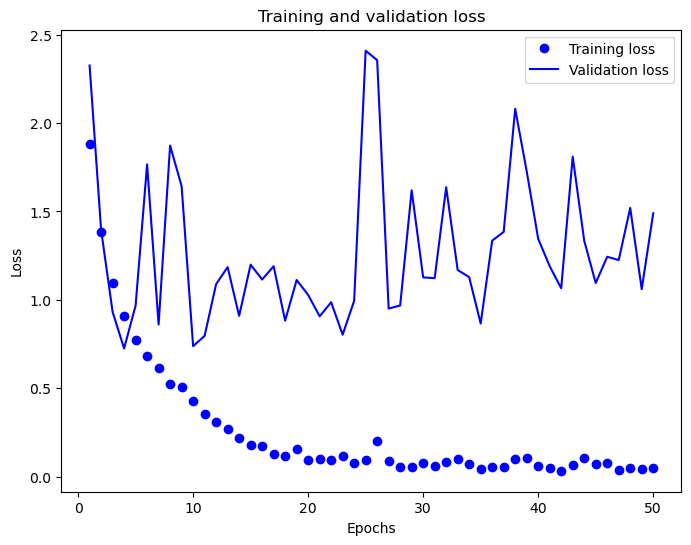

In [21]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

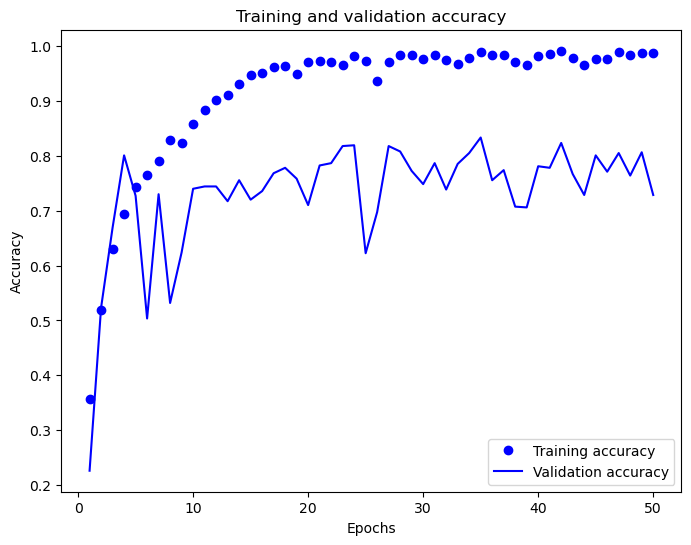

In [22]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# Save and export the model

model.save('model_nbac_basic_al2s.h5')

### Confusion matrix

48/48 [==============================] - 1s 5ms/step


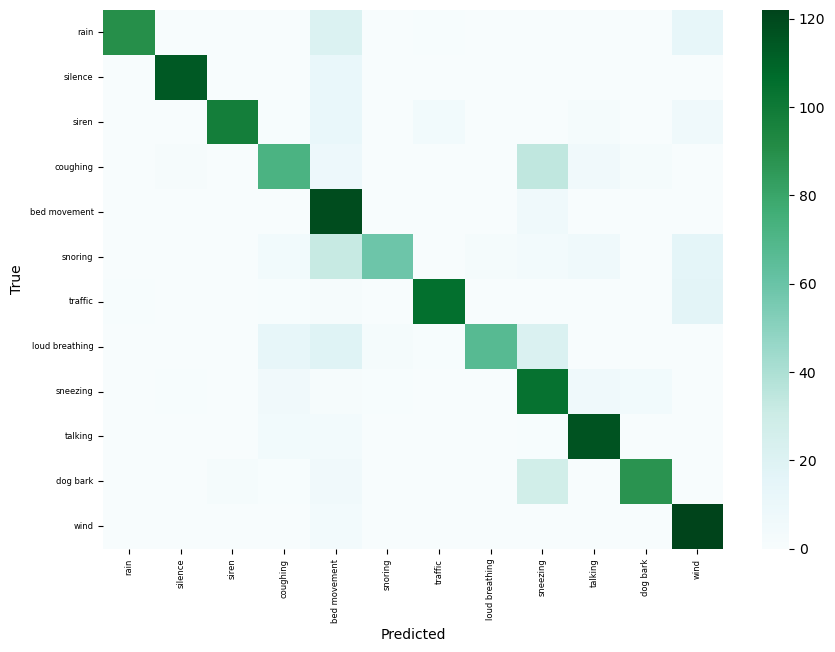

In [24]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Visualize the ouput of the LLF

In [25]:
idx = 55
sample = X_test_wav[idx]
sample = sample.reshape(1, AUDIO_LENGTH * SR) # Add a batch dimension

1/1 [==============================] - 0s 356ms/step


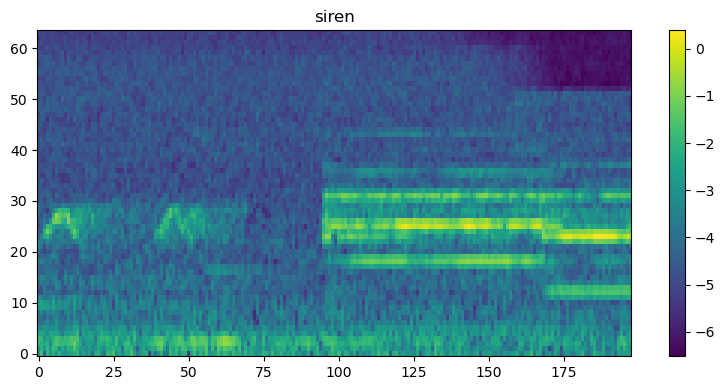

In [26]:
# Get the output of the SpectrogramLayer
spectrogram_model = Model(inputs=model.inputs, outputs=model.get_layer(index=0).output)
spectrogram_output = spectrogram_model.predict(sample)

# Create a figure with custom size (e.g., width=10 inches, height=6 inches)
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(reversed_labels[y_test[idx]])
spectrogram = spectrogram_output.squeeze().T  # Transpose the spectrogram and remove redundant dimensions

img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Depthwise Spearable Convolutions

In [27]:
class LLF(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)

        return log_mel_spectrogram

sample_rate = SR  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
AUDIO_LENGTH = 2

class HLFBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HLFBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.SeparableConv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.SeparableConv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        ])

    def call(self, inputs):
        return self.seq(inputs)

class EmbeddingsBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EmbeddingsBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GlobalAveragePooling2D(),
        ])

    def call(self, inputs):
        return self.seq(inputs)
    
HLF = HLFBlock(name='HLF')
Embeddings = EmbeddingsBlock(name='Embeddings')

# Define the model
model = Sequential([
    LLF(sample_rate, frame_length, frame_step, input_shape=(AUDIO_LENGTH*SR,)),
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_wav), np.array(y_val)))

Epoch 1/50


2023-06-17 16:50:37.067213: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/Embeddings/sequential_4/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


177/177 [==============================] - 8s 19ms/step - loss: 1.9440 - accuracy: 0.3337 - val_loss: 2.4952 - val_accuracy: 0.0891
Epoch 2/50
177/177 [==============================] - 2s 11ms/step - loss: 1.4560 - accuracy: 0.5044 - val_loss: 2.2870 - val_accuracy: 0.2291
Epoch 3/50
177/177 [==============================] - 2s 12ms/step - loss: 1.2364 - accuracy: 0.5766 - val_loss: 1.1943 - val_accuracy: 0.6690
Epoch 4/50
177/177 [==============================] - 2s 11ms/step - loss: 1.0843 - accuracy: 0.6306 - val_loss: 0.8175 - val_accuracy: 0.7595
Epoch 5/50
177/177 [==============================] - 2s 12ms/step - loss: 0.9601 - accuracy: 0.6765 - val_loss: 0.8142 - val_accuracy: 0.7242
Epoch 6/50
177/177 [==============================] - 2s 12ms/step - loss: 0.8723 - accuracy: 0.7077 - val_loss: 0.7488 - val_accuracy: 0.7751
Epoch 7/50
177/177 [==============================] - 2s 12ms/step - loss: 0.8011 - accuracy: 0.7318 - val_loss: 0.8059 - val_accuracy: 0.7454
Epoch 8/50

In [28]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

48/48 - 0s - loss: 1.0052 - accuracy: 0.7943 - 324ms/epoch - 7ms/step
Test loss: 1.0051746368408203
Test accuracy: 0.7943121790885925


In [29]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 48373


In [30]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf_1 (LLF)                 (None, 198, 64, 1)        0         
                                                                 
 HLF (HLFBlock)              (None, 12, 4, 128)        12265     
                                                                 
 Embeddings (EmbeddingsBlock  (None, 256)              33024     
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
 activation_1 (Activation)   (None, 12)                0         
                                                                 
Total params: 48,373
Trainable params: 47,925
Non-trainable params: 448
________________________________________________

### Visualization of the training process

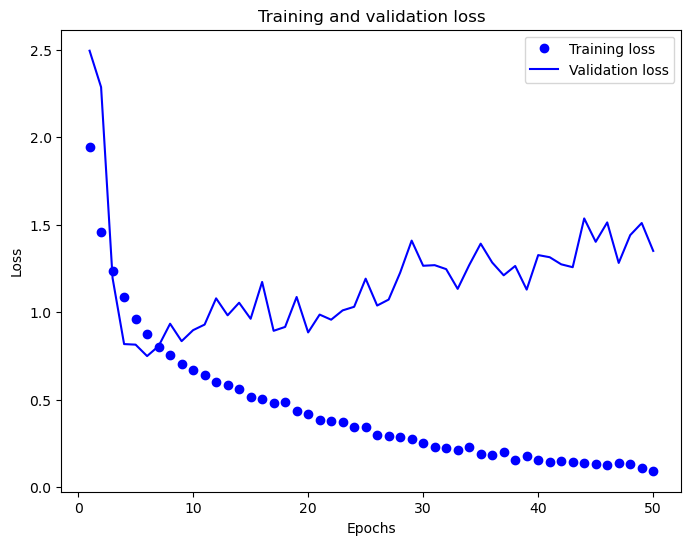

In [31]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

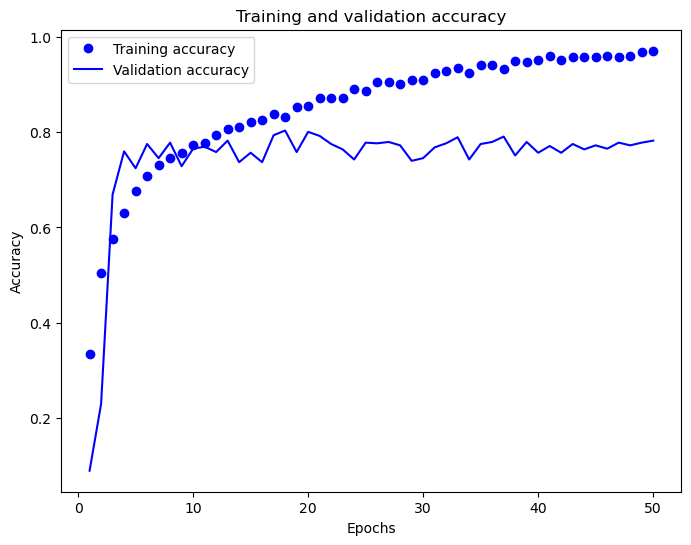

In [32]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
# Save and export the model

model.save('model_nbac_dw_al2s.h5')

### Confusion matrix

48/48 [==============================] - 1s 5ms/step


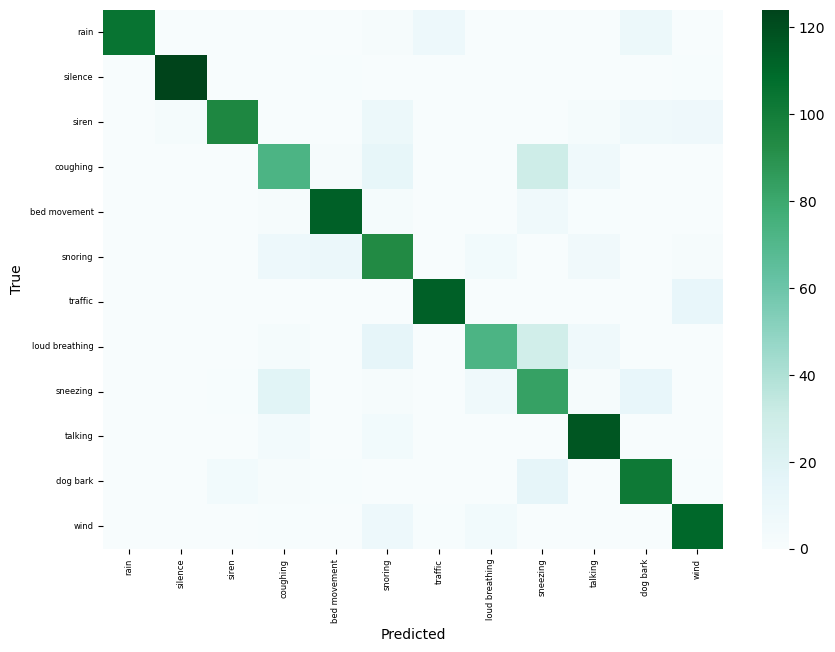

In [34]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Visualize the ouput of the LLF

In [35]:
idx = 55
sample = X_test_wav[idx]
sample = sample.reshape(1, AUDIO_LENGTH * SR) # Add a batch dimension

1/1 [==============================] - 0s 298ms/step


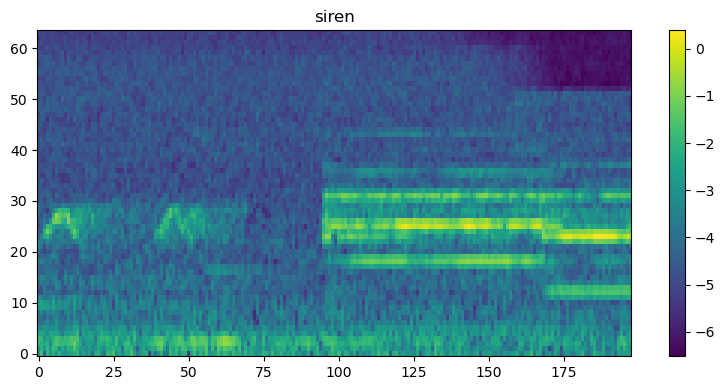

In [36]:
# Get the output of the SpectrogramLayer
spectrogram_model = Model(inputs=model.inputs, outputs=model.get_layer(index=0).output)
spectrogram_output = spectrogram_model.predict(sample)

# Create a figure with custom size (e.g., width=10 inches, height=6 inches)
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(reversed_labels[y_test[idx]])
spectrogram = spectrogram_output.squeeze().T  # Transpose the spectrogram and remove redundant dimensions

img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Transfer Learning with Mobilenet_v1

## Mobilenet_v1 with randomly initialized weights


In [37]:
# Load the MobileNetV1 model but exclude the top layers
mobilenet_model = MobileNet(weights=None, include_top=False, input_shape=(198, 64, 3))

class LLF_3channels(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF_3channels, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)
        
        # Convert 1-channel image to 3-channel image
        x = tf.repeat(log_mel_spectrogram, 3, axis=-1)
        
        return x

sample_rate = 16000  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
audio_length = sample_rate*2

class MobileNetEmbeddings(Model):
    def __init__(self, base_model, **kwargs):
        super(MobileNetEmbeddings, self).__init__(**kwargs)
        self.base_model = base_model
        self.pooling = GlobalAveragePooling2D()
        
    def call(self, inputs):
        x = self.base_model(inputs)
        return self.pooling(x)

MobileNet_embeddings = MobileNetEmbeddings(mobilenet_model, name="MobileNet_embeddings")

# Define the model
model = Sequential([
    LLF_3channels(sample_rate=sample_rate, frame_length=frame_length, frame_step=frame_step, input_shape=(audio_length,)),
    MobileNet_embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')
])

for layer in mobilenet_model.layers:
    layer.trainable = True

# Define a learning rate
learning_rate = 0.001/2 # With low learning rates the model gets stuck at local minumums that cause overfitting.
                        # With high learning rates the performance is inconsistent

# Initialize the Adam optimizer with the lower learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

# Define model checkpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

callbacks = [earlystopping, model_checkpoint]

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, 
                    validation_data=(np.array(X_val_wav), np.array(y_val)),
                    callbacks=callbacks)

Epoch 1/50
177/177 [==============================] - ETA: 0s - loss: 2.1286 - accuracy: 0.2581
Epoch 1: val_loss improved from inf to 2.57236, saving model to best_model.h5
177/177 [==============================] - 26s 49ms/step - loss: 2.1286 - accuracy: 0.2581 - val_loss: 2.5724 - val_accuracy: 0.0792
Epoch 2/50
177/177 [==============================] - ETA: 0s - loss: 1.6409 - accuracy: 0.4250
Epoch 2: val_loss did not improve from 2.57236
177/177 [==============================] - 6s 37ms/step - loss: 1.6409 - accuracy: 0.4250 - val_loss: 2.6676 - val_accuracy: 0.0792
Epoch 3/50
177/177 [==============================] - ETA: 0s - loss: 1.4216 - accuracy: 0.4903
Epoch 3: val_loss did not improve from 2.57236
177/177 [==============================] - 7s 37ms/step - loss: 1.4216 - accuracy: 0.4903 - val_loss: 3.0336 - val_accuracy: 0.0891
Epoch 4/50
177/177 [==============================] - ETA: 0s - loss: 1.2432 - accuracy: 0.5590
Epoch 4: val_loss improved from 2.57236 to 1.70

In [38]:
model.load_weights('best_model.h5')

In [39]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

48/48 - 1s - loss: 0.7913 - accuracy: 0.7963 - 742ms/epoch - 15ms/step
Test loss: 0.791288435459137
Test accuracy: 0.7962962985038757


In [40]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 3241164


In [41]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf_3channels (LLF_3channel  (None, 198, 64, 3)       0         
 s)                                                              
                                                                 
 MobileNet_embeddings (Mobil  (None, 1024)             3228864   
 eNetEmbeddings)                                                 
                                                                 
 dense_2 (Dense)             (None, 12)                12300     
                                                                 
 activation_2 (Activation)   (None, 12)                0         
                                                                 
Total params: 3,241,164
Trainable params: 3,219,276
Non-trainable params: 21,888
_________________________________________________________________


### Visualization of the training process

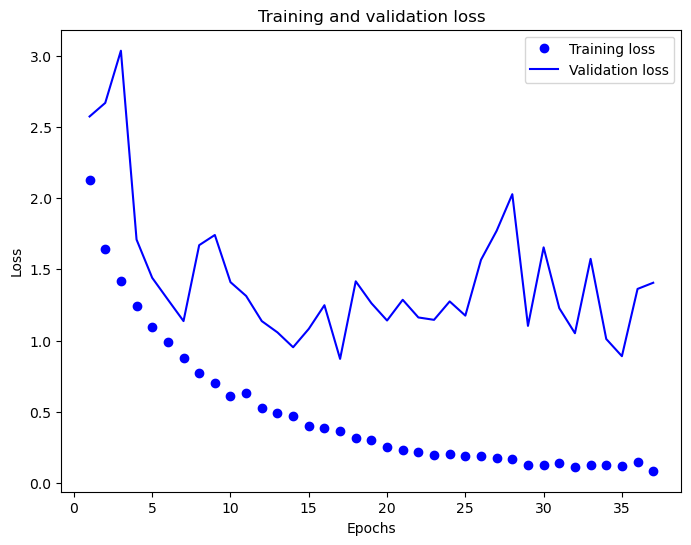

In [42]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

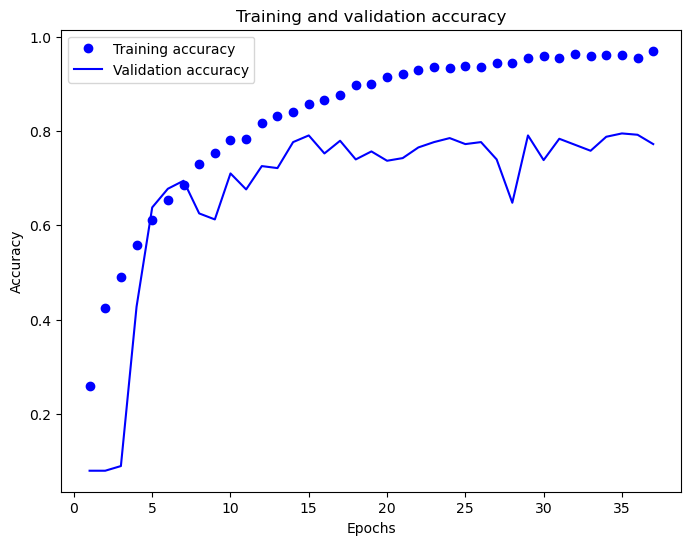

In [43]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [44]:
# Save and export the model

model.save('model_nbac_mobilenet_random_al2s.h5')

### Confusion matrix

48/48 [==============================] - 1s 12ms/step


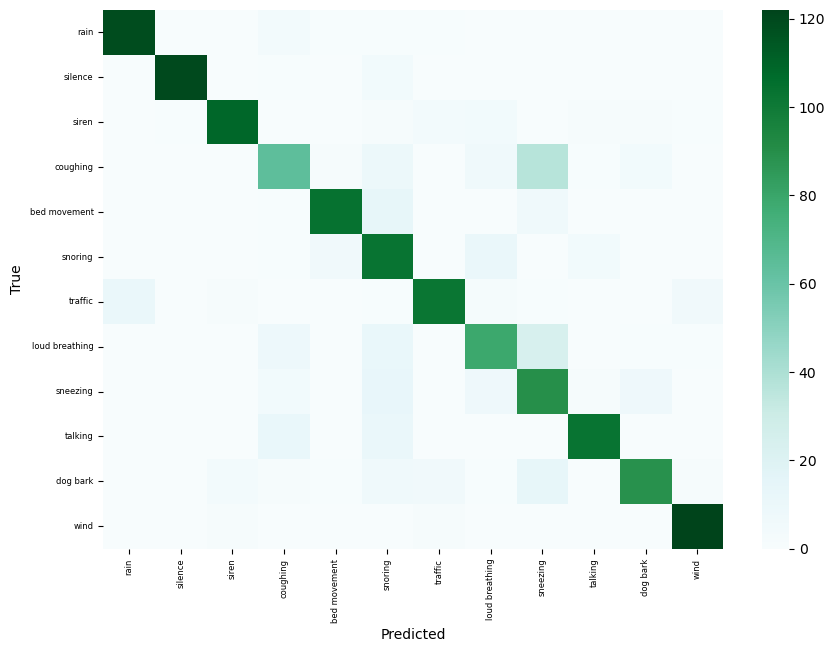

In [45]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Transfer learning with Imagenet


In [46]:
# Load the MobileNetV1 model but exclude the top layers
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(198, 64, 3))

class LLF_3channels(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF_3channels, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)
        
        # Convert 1-channel image to 3-channel image
        x = tf.repeat(log_mel_spectrogram, 3, axis=-1)
        
        return x

sample_rate = 16000  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
audio_length = sample_rate*2

class MobileNetEmbeddings(Model):
    def __init__(self, base_model, **kwargs):
        super(MobileNetEmbeddings, self).__init__(**kwargs)
        self.base_model = base_model
        self.pooling = GlobalAveragePooling2D()
        
    def call(self, inputs):
        x = self.base_model(inputs)
        return self.pooling(x)

MobileNet_embeddings = MobileNetEmbeddings(mobilenet_model, name="MobileNet_embeddings")

# Define the model
model = Sequential([
    LLF_3channels(sample_rate=sample_rate, frame_length=frame_length, frame_step=frame_step, input_shape=(audio_length,)),
    MobileNet_embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')
])

for layer in mobilenet_model.layers[:20]: #The first 20 layers of the model are frozen
    layer.trainable = False

# Define a learning rate
learning_rate = 0.001/2 # With low learning rates the model gets stuck at local minumums that cause overfitting.
                        # With high learning rates the performance is inconsistent

# Initialize the Adam optimizer with the lower learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

# Define model checkpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

callbacks = [earlystopping, model_checkpoint]

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, 
                    validation_data=(np.array(X_val_wav), np.array(y_val)),
                    callbacks=callbacks)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/50
175/177 [============================>.] - ETA: 0s - loss: 1.3280 - accuracy: 0.5746
Epoch 1: val_loss improved from inf to 1.94300, saving model to best_model.h5
177/177 [==============================] - 19s 37ms/step - loss: 1.3242 - accuracy: 0.5757 - val_loss: 1.9430 - val_accuracy: 0.6153
Epoch 2/50
175/177 [============================>.] - ETA: 0s - loss: 0.7113 - accuracy: 0.7588
Epoch 2: val_loss improved from 1.94300 to 1.10138, saving model to best_model.h5
177/177 [==============================] - 5s 30ms/step - loss: 0.7120 - accuracy: 0.7588 - val_loss: 1.1014 - val_accuracy: 0.7595
Epoch 3/50
176/177 [============================>.] - ETA: 0s - loss: 0.4472 - accuracy: 0.8484
Epoch 3: val_loss improved from 1.10138 to 0.95316, saving model to best_model.h5
177/177 [==============================] - 6s 32ms/step - loss: 0.4475 - accuracy: 0.8483 - val_loss: 0.9532 - val_accuracy: 0.7624
Epoch 4/

In [47]:
model.load_weights('best_model.h5')

In [48]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

48/48 - 1s - loss: 0.7477 - accuracy: 0.8406 - 640ms/epoch - 13ms/step
Test loss: 0.7476516962051392
Test accuracy: 0.8406084775924683


In [49]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 3241164


In [50]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf_3channels_1 (LLF_3chann  (None, 198, 64, 3)       0         
 els)                                                            
                                                                 
 MobileNet_embeddings (Mobil  (None, 1024)             3228864   
 eNetEmbeddings)                                                 
                                                                 
 dense_3 (Dense)             (None, 12)                12300     
                                                                 
 activation_3 (Activation)   (None, 12)                0         
                                                                 
Total params: 3,241,164
Trainable params: 3,205,260
Non-trainable params: 35,904
_________________________________________________________________


### Visualization of the training process

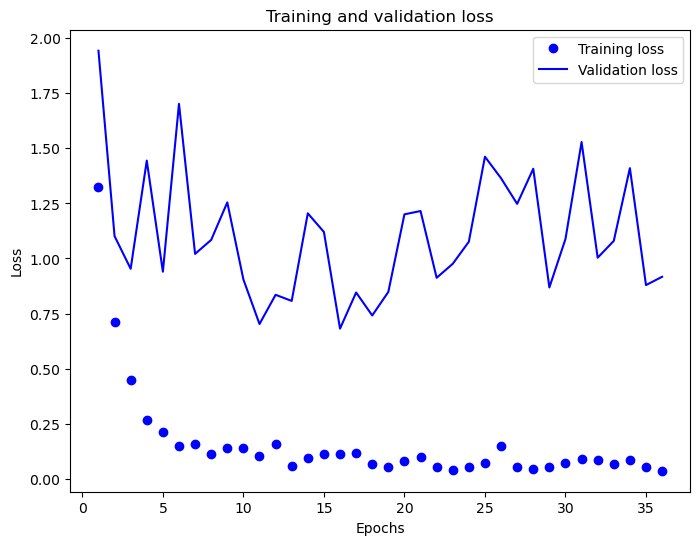

In [51]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

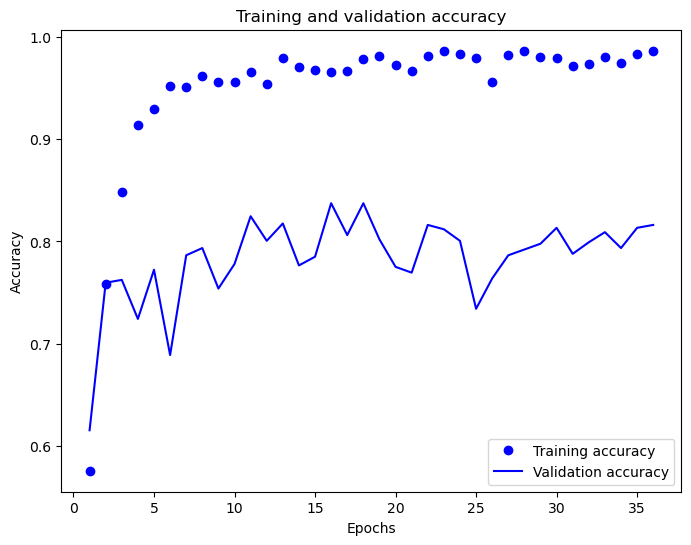

In [52]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
# Save and export the model

model.save('model_nbac_mobilenet_imagenet_al2s.h5')

### Confusion matrix

48/48 [==============================] - 1s 12ms/step


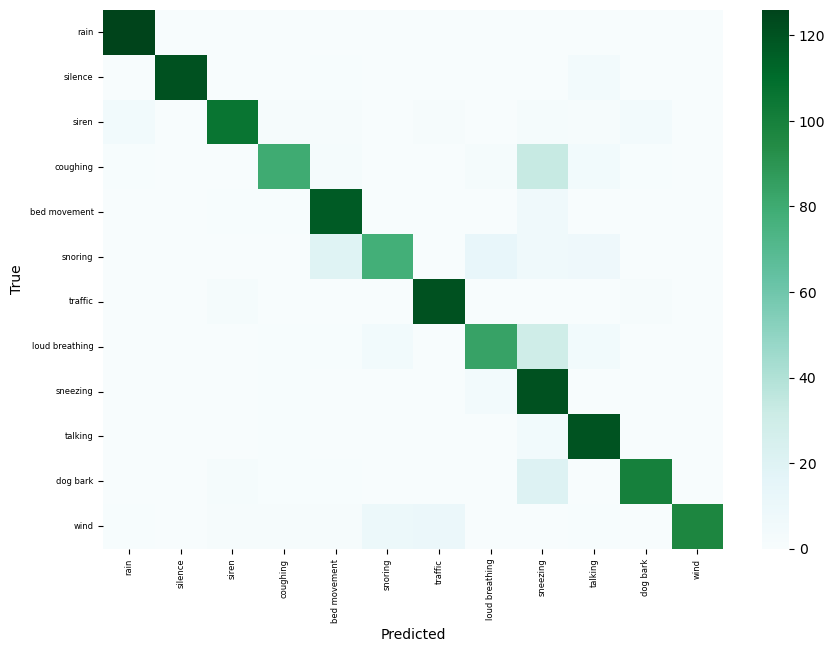

In [54]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()